In [1]:
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
MERGEDTAGSCOMM = 'finalgamingtagcomment.parquet'


In [3]:
merged_commtags = pd.read_parquet(MERGEDTAGSCOMM)
merged_commtags.head()

,author,display_id,likes,replies,tags,upload_date
0,2,9pQILRT42Cg,0,0,"faze,fazeclan,banks,faze banks,my new girlfrie...",2017-06-22 00:00:00
1,2,PWWRzCyuiFU,0,0,,2018-06-03 00:00:00
2,5,9MuGpmXGlsY,0,0,"fortnite,fortnite gameplay,fortnite gotta chil...",2019-07-13 00:00:00
3,5,UvZPbfUkMGw,0,0,"fortnite,fortnite top 10,top 10 crazy ways peo...",2019-06-17 00:00:00
4,11,qj9sjQjQ19M,0,0,"مقلب ببجي,ببجي موبايل,pubg mobile,مقلب ببجي مو...",2019-02-22 00:00:00


In [12]:
colors = {'call of duty':'black','fifa': 'blue', 'pes': 'green', 'fortnite': 'red', 'league of legends': 'orange', 'minecraft': 'purple'}

frames = {tag: merged_commtags[merged_commtags['tags'].str.contains(tag, case=False)] for tag in tqdm(colors)}

print(frames)

100%|██████████| 6/6 [03:08<00:00, 31.44s/it]

{'call of duty':            author   display_id  likes  replies  \
41             16  P4soUB4N_7Y      0        0   
114            16  9BRuBptSTMk      0        0   
221            16  -D7KM5S4j94      0        0   
249            16  P4soUB4N_7Y      0        0   
259            16  _zLovAyL6YA      2        0   
...           ...          ...    ...      ...   
25658509  6695065  iO923YxI9OA      0        0   
25658639  6695100  GY4cFGgD7U0      0        0   
25658642  6695100  AinJbYHmnJo      0        0   
25658646  6695100  UOOVBatsYzY      1        0   
25658649  6695100  2mIlFC52bqc      0        0   

                                                       tags  \
41        Call of Duty Mobile,Call of Duty on Mobile,COD...   
114       apex legends gameplay,fortnite,battle royale,h...   
221       iferg,HawksNest,NoahFromYoutube,call of duty m...   
249       Call of Duty Mobile,Call of Duty on Mobile,COD...   
259       PUBG,playerunknowns,battlegrounds,battle royal...   
... 

In [14]:
for game in frames.keys():
    frames[game]['game'] = game

/var/folders/28/gvth1rss5s926dk3t6z7nxz00000gn/T/ipykernel_49679/3425493321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames[game]['game'] = game


In [15]:
df = pd.concat(frames.values()).drop(columns=['tags', 'likes', 'replies']).sort_values(by='upload_date')

<Axes: xlabel='upload_date'>

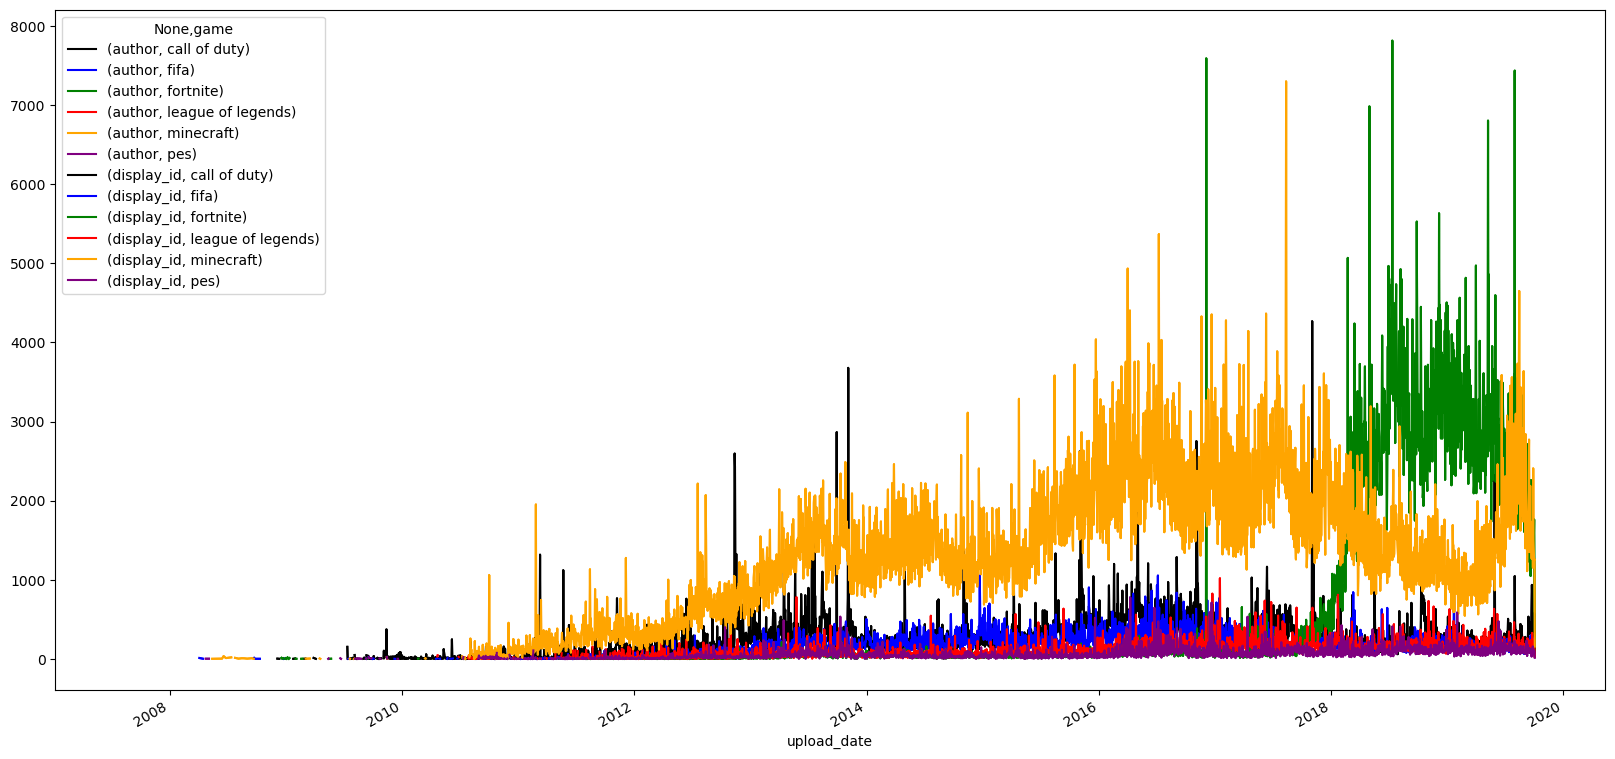

In [16]:
df['upload_date'] = pd.to_datetime(df['upload_date'])
df.groupby(['upload_date', 'game']).count().unstack().plot(figsize=(20,10), color=[colors[game] for game in frames.keys()])

In [17]:
uniqueauth = df['author'].unique()
author_dict = {author: None for author in uniqueauth}

upload_dates = df['upload_date'].unique()
dates_dict = {date: [] for date in upload_dates}

In [18]:
for index, row in tqdm(df.iterrows()):
    # Get the tags of the current author
    author_tags = row['game']
    
    # Iterate over each tag in tags
    for tag in frames.keys():
        # Check if the current tag is in the author_tags
        if tag in author_tags:
            # Perform your desired action here
            if author_dict[row['author']] == None:
                author_dict[row['author']] = tag
            else:
                dates_dict[row['upload_date']].append((author_dict[row['author']],tag))
                author_dict[row['author']] = tag


8497286it [01:56, 73155.17it/s]


In [19]:
from itertools import permutations
from collections import Counter
combs = list(permutations(list(frames.keys()), 2))

In [20]:
migrations = {}
for date in tqdm(dates_dict.keys()):
    occs = Counter(dates_dict[date])
    for combination in combs:
        if combination not in occs.keys():
            occs[combination] = 0
    date_dict = {
            'migrations': list(occs.items())
        }
    migrations[date] = date_dict

100%|██████████| 3760/3760 [00:00<00:00, 12549.43it/s]


In [22]:
import networkx as nx

In [24]:
dates_list = list(dates_dict.keys())
dates_list.sort()
selected_date = dates_list[1]
selected_date


Timestamp('2008-01-04 00:00:00')

In [25]:
m = migrations[selected_date]
migr = m['migrations']
migr

[(('pes', 'pes'), 4),
 (('call of duty', 'fifa'), 0),
 (('call of duty', 'pes'), 0),
 (('call of duty', 'fortnite'), 0),
 (('call of duty', 'league of legends'), 0),
 (('call of duty', 'minecraft'), 0),
 (('fifa', 'call of duty'), 0),
 (('fifa', 'pes'), 0),
 (('fifa', 'fortnite'), 0),
 (('fifa', 'league of legends'), 0),
 (('fifa', 'minecraft'), 0),
 (('pes', 'call of duty'), 0),
 (('pes', 'fifa'), 0),
 (('pes', 'fortnite'), 0),
 (('pes', 'league of legends'), 0),
 (('pes', 'minecraft'), 0),
 (('fortnite', 'call of duty'), 0),
 (('fortnite', 'fifa'), 0),
 (('fortnite', 'pes'), 0),
 (('fortnite', 'league of legends'), 0),
 (('fortnite', 'minecraft'), 0),
 (('league of legends', 'call of duty'), 0),
 (('league of legends', 'fifa'), 0),
 (('league of legends', 'pes'), 0),
 (('league of legends', 'fortnite'), 0),
 (('league of legends', 'minecraft'), 0),
 (('minecraft', 'call of duty'), 0),
 (('minecraft', 'fifa'), 0),
 (('minecraft', 'pes'), 0),
 (('minecraft', 'fortnite'), 0),
 (('minecr

In [35]:
print(dates_list)

[Timestamp('2007-08-16 00:00:00'), Timestamp('2008-01-04 00:00:00'), Timestamp('2008-04-04 00:00:00'), Timestamp('2008-04-15 00:00:00'), Timestamp('2008-04-24 00:00:00'), Timestamp('2008-05-04 00:00:00'), Timestamp('2008-05-14 00:00:00'), Timestamp('2008-06-14 00:00:00'), Timestamp('2008-06-19 00:00:00'), Timestamp('2008-06-26 00:00:00'), Timestamp('2008-07-13 00:00:00'), Timestamp('2008-07-19 00:00:00'), Timestamp('2008-07-20 00:00:00'), Timestamp('2008-07-25 00:00:00'), Timestamp('2008-08-05 00:00:00'), Timestamp('2008-08-15 00:00:00'), Timestamp('2008-08-23 00:00:00'), Timestamp('2008-09-01 00:00:00'), Timestamp('2008-09-16 00:00:00'), Timestamp('2008-09-22 00:00:00'), Timestamp('2008-09-23 00:00:00'), Timestamp('2008-09-26 00:00:00'), Timestamp('2008-10-11 00:00:00'), Timestamp('2008-10-26 00:00:00'), Timestamp('2008-10-28 00:00:00'), Timestamp('2008-11-03 00:00:00'), Timestamp('2008-11-15 00:00:00'), Timestamp('2008-11-18 00:00:00'), Timestamp('2008-11-19 00:00:00'), Timestamp('20

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import math
# Assuming 'dates_dict', 'migrations', and 'frames' are defined elsewhere in your code
# ...

dates_list = list(dates_dict.keys())
dates_list.sort()  # Sorting the list of dates


G = nx.DiGraph()
@interact(date=IntSlider(min=0, max=len(dates_list)-1, step=1))
def plot(date):
    if date>1:
         G.remove_edges_from(list(G.edges()))
    
    
    selected_date = dates_list[date]
    m = migrations[selected_date]
    migr = m['migrations']
    # Add edges with weights
    weights = []
    num_users = {game: 0 for game in frames.keys()}
            
    for migration in migr:
        origin = migration[0][0]
        destination = migration[0][1]
        count = migration[1]
        weights.append(count)
        if origin == destination:
            num_users[origin] += count
        else: 
            if count >0:
                G.add_edge(origin, destination, weight=count)

        # Get edge weights  
    edge_weights = [weight for weight in weights]
    scaled_weights = [math.log(1 + weight) for weight in edge_weights]

    # Normalize edge weights for visualization purposes
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)
    min_scaled_weight = min(scaled_weights)
    max_scaled_weight = max(scaled_weights)

    normalized_weights = [2 + 4 * (scaled_weight - min_scaled_weight) / (1+max_scaled_weight - min_scaled_weight) for scaled_weight in scaled_weights]
    node_sizes = [300+ 5 * num_users[node] for node in G.nodes]
    scaled_node_sizes = [math.log(1 + size) for size in node_sizes]

    # Draw the graph
    pos = nx.circular_layout(G)

    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color="skyblue", font_size=14, font_color="black", width=normalized_weights, edge_color='gray', arrowsize=20, connectionstyle="arc3,rad=0.1")

    # Show the graph
    plt.title("Migration of users between games on " + str(selected_date))
    plt.show()


interactive(children=(IntSlider(value=0, description='date', max=3759), Output()), _dom_classes=('widget-inter…

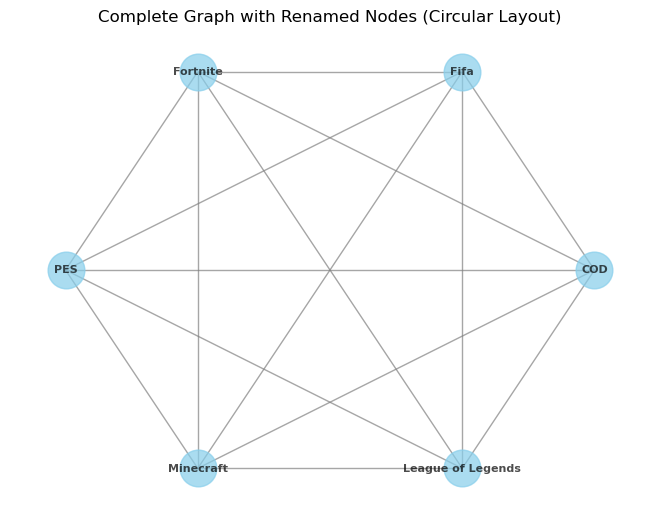

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a complete graph with 6 nodes
G = nx.complete_graph(6)

# Rename the nodes
node_labels = {0: 'COD', 1: 'Fifa', 2: 'Fortnite', 3: 'PES', 4: 'Minecraft', 5: 'League of Legends'}
G = nx.relabel_nodes(G, node_labels)

# Draw the graph using a circular layout
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', edge_color='gray', linewidths=1, alpha=0.7)

# Show the plot
plt.title('Complete Graph with Renamed Nodes (Circular Layout)')
plt.show()


In [ ]:
def plot(date):
    
    G = nx.MultiDiGraph()
    nodes = set()
    
    # Add edges with weights
    weights = []
    num_users = {game: 0 for game in frames.keys()}
    for data in data:
        print(data)
        migration_data = data['migrations']
        for migration in migration_data:
            origin = migration[0][0]
            destination = migration[0][1]
            count = migration[1]
            weights.append(count)
            if origin == destination:
                num_users[origin] += count
            else: 
                G.add_edge(origin, destination, weight=count)

            
    # Get edge weights  
    edge_weights = [weight for weight in weights]
    print(num_users)
    # Normalize edge weights for visualization purposes
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)
    normalized_weights = [2 + 8 * (weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]
    node_sizes = [100 * num_users[node] for node in G.nodes]

    # Draw the graph
    pos = nx.circular_layout(G)


    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color="skyblue", font_size=14, font_color="black", width=normalized_weights, edge_color='gray', arrowsize=20)

    # Show the graph
    plt.show()
